The given code is a Python script for performing binary classification on the Titanic dataset using various machine learning classifiers and evaluating their performance.

Dataset: https://www.kaggle.com/datasets/brendan45774/test-file

### Libraries Import
- The script starts by importing necessary libraries such as `pandas`, `matplotlib`, `numpy`, and various modules from `sklearn` for data manipulation, visualization, and machine learning tasks.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading and Preprocessing
- It loads the Titanic dataset from a CSV file using `pd.read_csv('tested.csv')`.
- It then splits the data into features (`X`) and target variable (`y`).
- Next, it defines a `preprocessor` to handle different types of features (categorical and numeric) using `ColumnTransformer`.
- It also creates a preprocessing pipeline to apply transformations and impute missing values.

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Neuronexus Innovations/NeuroNexus Innovations - Data Science/Titanic Survival Prediction/tested.csv')

# Split the data into features and target variable
X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = data['Survived']

# Updated preprocessing steps for different types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), ['Sex', 'Embarked']),  # One-hot encode categorical features
        ('num', StandardScaler(), ['Age', 'SibSp', 'Parch', 'Fare']),  # Scale numeric features
        ('passthrough', 'passthrough', ['Pclass'])  # No preprocessing for Pclass
    ],
    remainder='drop'  # Drop columns not specified
)

### Model Training and Evaluation
- The script then splits the data into training and testing sets using `train_test_split`.
- It initializes multiple classifiers suitable for different feature types using dictionaries.
- A function `plot_auc_roc` is defined to plot the AUC-ROC curve for each classifier with the help of the specified preprocessing steps.
- Another function `print_evaluation_metrics` is defined to print evaluation metrics such as accuracy, precision, recall, F1-score, and cross-validation scores for each classifier.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers suitable for different feature types
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),  # Use Gaussian Naive Bayes for features with negative values
    'Decision Tree (Gini)': DecisionTreeClassifier(criterion='gini'),
    'Decision Tree (Entropy)': DecisionTreeClassifier(criterion='entropy'),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True)  # Enable probability estimates for SVM
}

# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the defined column transformations
    ('imputer', SimpleImputer(strategy='mean'))  # Impute missing values using mean strategy
])

In [ ]:
def plot_auc_roc(classifier, X_train, y_train, X_test, y_test):
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)  # Fit the pipeline on training data
    if hasattr(classifier, "predict_proba"):
        y_score = pipeline.predict_proba(X_test)[:,1]  # Get predicted probabilities for positive class
    else:
        y_score = pipeline.decision_function(X_test)  # Get decision function scores

    fpr, tpr, _ = roc_curve(y_test, y_score)  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Calculate AUC for ROC curve
    plt.plot(fpr, tpr, label=f'{classifier.__class__.__name__} (AUC = {roc_auc:.2f})')  # Plot AUC-ROC curve

In [ ]:
# Function to print evaluation metrics for classifiers
def print_evaluation_metrics(name, pipeline, X_test, y_test):
    pipeline.fit(X_train, y_train)  # Fit the pipeline on training data
    y_pred = pipeline.predict(X_test)  # Predict using the fitted pipeline
    print(f"\nClassifier: {name}")  # Print classifier name
    print("Classification Report:")
    print(classification_report(y_test, y_pred))  # Print classification report
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    print(f"Accuracy: {accuracy:.2f}")  # Print accuracy
    cv_scores = cross_val_score(pipeline, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42))  # Cross-validation scores
    print(f"Cross-validation Scores: {cv_scores}")

    if 'predict_proba' in dir(pipeline.named_steps['classifier']):
        y_score = pipeline.predict_proba(X_test)[:,1]  # Get predicted probabilities for positive class
        y_pred = np.where(y_score > 0.5, 1, 0)  # Convert probabilities to binary predictions
    else:
        y_score = pipeline.decision_function(X_test)  # Get decision function scores

    if 'predict_proba' not in dir(pipeline.named_steps['classifier']):
        precision = precision_score(y_test, y_pred)  # Calculate precision
        recall = recall_score(y_test, y_pred)  # Calculate recall
        f1 = f1_score(y_test, y_pred)  # Calculate F1 score
        print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")  # Print precision, recall, and F1 score

### AUC-ROC Curve Plotting
- After defining these functions, the script plots the AUC-ROC curves for all the classifiers and displays the plot.

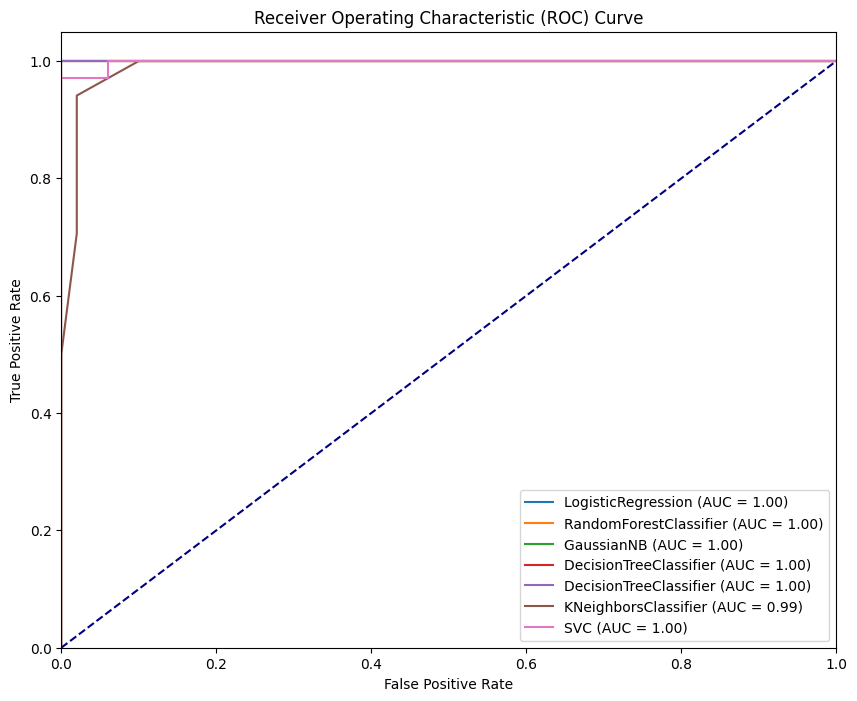

In [ ]:
# Plot the AUC-ROC curve for each classifier
plt.figure(figsize=(10, 8))  # Set figure size
for name, classifier in classifiers.items():
    plot_auc_roc(classifier, X_train, y_train, X_test, y_test)  # Call plot_auc_roc function for each classifier

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Plot diagonal line for reference
plt.xlim([0.0, 1.0])  # Set x-axis limits
plt.ylim([0.0, 1.05])  # Set y-axis limits
plt.xlabel('False Positive Rate')  # X-axis label
plt.ylabel('True Positive Rate')  # Y-axis label
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Set plot title
plt.legend(loc='lower right')  # Add legend at lower right corner
plt.show()  # Display the plot

### Classifier Evaluation
- Finally, the script loops through each classifier, creates a pipeline with preprocessing steps and the classifier, and evaluates its performance using the `print_evaluation_metrics` function.

In [ ]:
# Loop through each classifier and calculate the evaluation metrics
for name, classifier in classifiers.items():
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline),
        ('classifier', classifier)
    ])
    print_evaluation_metrics(name, pipeline, X_test, y_test)  # Call print_evaluation_metrics function for each classifier


Classifier: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Accuracy: 1.00
Cross-validation Scores: [1. 1. 1. 1. 1.]

Classifier: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        34

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84

Accuracy: 1.00
Cross-validation Scores: [1. 1. 1. 1. 1.]

Classifier: Gaussian Naive Bayes
Classification Report:
              precision    recall  f1-score   support

           0  


The script efficiently handles data preprocessing, model training, and evaluation while providing visualizations for performance assessment.